In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data\data_stunting_smote.csv')


In [3]:
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_Normal,Stunting_Sangat Pendek,Stunting_Pendek,Stunting_Tinggi
0,0,0.791667,0.890909,0.759259,False,False,False,True
1,0,0.833333,0.638182,0.462963,False,False,True,False
2,0,0.416667,0.661818,0.574074,True,False,False,False
3,1,0.083333,0.140000,0.450617,False,True,False,False
4,1,0.208333,0.250909,0.611111,False,True,False,False


#### Splitting Data

In [4]:
x = df.drop(['Stunting_Normal','Stunting_Sangat Pendek','Stunting_Pendek','Stunting_Tinggi'], axis =1)
y = df[['Stunting_Normal','Stunting_Sangat Pendek','Stunting_Pendek','Stunting_Tinggi']]

X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print ("Jumlah data latih Stunting:", len(y_train_st))
print ("Jumlah data uji Stunting:", len(y_test_st))



Jumlah data latih Stunting: 214576
Jumlah data uji Stunting: 53644


In [5]:
np.save('data/data_uji/X_test_st.npy', X_test_st)
np.save('data/data_uji/y_test_st.npy', y_test_st)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model_stunting = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_st.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output neuron untuk 4 kelas
])

model_stunting.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # loss untuk multi-class one-hot label
    metrics=['accuracy']
)

model_stunting.summary()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,156 (35.77 KB)

 Trainable params: 9,156 (35.77 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import Callback
class StopAtAccuracy(Callback):
    def __init__(self, target=0.9):
        super(StopAtAccuracy, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')  # ganti 'val_accuracy' kalau mau validasi
        if accuracy is not None:
            if accuracy >= self.target:
                print(f"\nAkurasi sudah mencapai {accuracy:.4f}, training dihentikan.")
                self.model.stop_training = True

# Pakai callback ini saat training:
stop_callback = StopAtAccuracy(target=0.95)

history_stunting = model_stunting.fit(
    X_train_st, y_train_st,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_callback]
)


Epoch 1/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7006 - loss: 0.6645 - val_accuracy: 0.9397 - val_loss: 0.2019
Epoch 2/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9007 - loss: 0.2579 - val_accuracy: 0.9447 - val_loss: 0.1437
Epoch 3/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9187 - loss: 0.2133 - val_accuracy: 0.9555 - val_loss: 0.1303
Epoch 4/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9279 - loss: 0.1901 - val_accuracy: 0.9536 - val_loss: 0.1144
Epoch 5/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9332 - loss: 0.1774 - val_accuracy: 0.9496 - val_loss: 0.1203
Epoch 6/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9335 - loss: 0.1771 - val_accuracy: 0.9607 - val_loss: 0.1103
Epoch 7/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9348 - loss: 0.1735 - val_accuracy: 0.9542 - val_loss: 0.1165
Epoch 8/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9360 - loss: 0

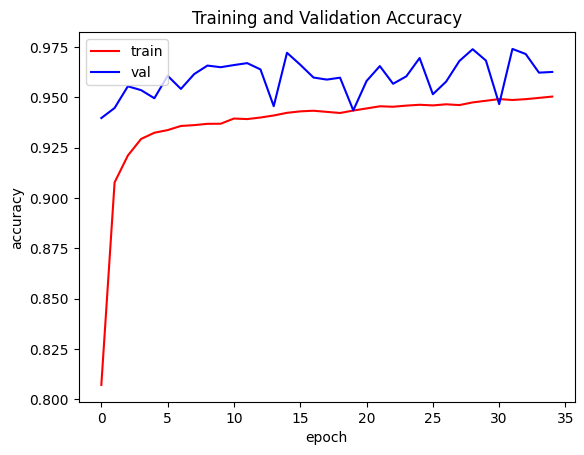

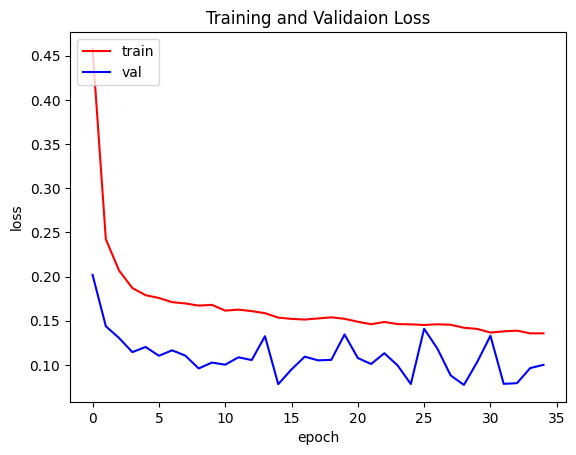

In [8]:
import matplotlib.pyplot as plt

acc = history_stunting.history['accuracy']
val_acc = history_stunting.history['val_accuracy']
loss = history_stunting.history['loss']
val_loss = history_stunting.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

### Konversi Model

In [9]:
# menyimpan model h5 version
model_stunting.save('Model_Stunting/model_stunting.h5')

In [10]:
import tensorflow as tf
import tensorflow as tf

# Load model dari file .h5
model = tf.keras.models.load_model("Model_Stunting/model_stunting.h5")

# Compile ulang model jika ingin menghindari warning
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Simpan ke format SavedModel (Keras 3+ cara baru)
model.export("Model_Stunting")


INFO:tensorflow:Assets written to: Model_Stunting\assets


INFO:tensorflow:Assets written to: Model_Stunting\assets


Saved artifact at 'Model_Stunting'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1479647618320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1479647624848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1479647623120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1479647623312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1479628210448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1479628212176: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [11]:
import tensorflow as tf

# Path ke direktori SavedModel
saved_model_dir = "Model_Stunting"

# Buat converter dari SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# (Opsional) Jika ingin optimasi ukuran
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi model
tflite_model = converter.convert()

# Simpan model ke file .tflite
with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi dan disimpan sebagai 'my_model.tflite'")


Model berhasil dikonversi dan disimpan sebagai 'my_model.tflite'
